# Open Access Evidence in Unpaywall using Python

*Analyzing the open access status of scholarly articles is a challenging task that many libraries, universities and researchers are facing. In this blog post, we discuss a Python based approach for analyzing journal articles using the Unpaywall database. In particular, we build upon the results of an existing blog article which used R and provide a new python implementation.* 

The [Unpaywall](https://unpaywall.org/) database is a collection of millions of scholarly fulltext articles that were harvested from a variety of different repositories and services like [PubMed Central](https://www.ncbi.nlm.nih.gov/pmc/) and [DOAJ](https://doaj.org/). Although Unpaywall offers a REST API to query the Unpaywall database, it is more convenient and efficient to use the provided [database snapshots](https://unpaywall.org/products/snapshot), which are usually released twice a year.

In this blog post, we discuss the results from the blog article "[Open Access Evidence in Unpaywall](https://subugoe.github.io/scholcomm_analytics/posts/unpaywall_evidence/)" by Najko Jahn and Anne Hobert by comparing different database snapshots obtained from Unpaywall. Since the article was published on May 7th, 2019, Unpaywall has recently released a new data dump with up-to-date information about scholarly journal articles. Therefore it might be interesting to see how the change in data impacts the results of our analysis compared to the previous blog article. For this post we are using the Unpaywall data dump from February 2020.

In order to query the Unpaywall dataset, which is stored in Google BigQuery, we use the [google-cloud-bigquery](https://googleapis.dev/python/bigquery/latest/index.html) package. By default, this package is not shipped with [pandas](https://pandas.pydata.org/). However, we recommend to use this package along with pandas to have a better experience. The major reason for this being, that the queried data can easily be exported into a pandas DataFrame. 

In [1]:
from google.cloud import bigquery
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import seaborn as sns
import upsetplot

The setup for the Google BigQuery Python client is very simple. Firstly, we import bigquery from the google.cloud package and create a client object by passing the project name as a parameter. If we didn´t set our credentials for the Google Cloud service yet, Google asks us to verify our client. This can be done by simply exporting an API-Key provided by Google into the working environment or by installing the official [Google Cloud SDK](https://cloud.google.com/sdk). A detailed description on how to authenticate the client can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html). Notice that our project-database has restricted access.

In [2]:
%%capture
client = bigquery.Client(project='api-project-764811344545')

According to the aforementioned blog article, the dataset being used has two tables, containing records between 2008 and 2018. For reusability, we define two variables, which are holding the table´s names to call them in SQL queries. We are also using the improved string formatting syntax which is a new feature since Python 3.6.

In [3]:
# database snapshots
upw_08_12 = '`oadoi_full.mongo_upwFeb20_08_12`'
upw_13_18 = '`oadoi_full.mongo_upwFeb20_13_20`'

We can query the project-database by using the `query` method on our created client object. In this example we were requesting ten journal articles that were published in 2018. We can pass the SQL query simply as a string into our `query` method. Next we can chain the `to_dataframe` method on our query to get a pandas DataFrame.

In [4]:
client.query(f"""
            SELECT * 
            FROM {upw_13_18} 
            WHERE year=2018
            AND genre="journal-article" 
            LIMIT 10
            """).to_dataframe()

doi            genre  is_paratext  is_oa  \
0         10.1103/physrevd.98.052010  journal-article        False   True   
1          10.1142/s1793524518500614  journal-article        False   True   
2           10.3389/fpsyt.2017.00260  journal-article        False   True   
3           10.3389/fnagi.2018.00293  journal-article        False   True   
4           10.1074/jbc.ra118.006025  journal-article        False   True   
5           10.3389/fendo.2018.00159  journal-article        False   True   
6          10.32709/akusosbil.468636  journal-article        False   True   
7  10.11606/s1518-8787.2018052016291  journal-article        False   True   
8         10.1103/physreva.98.010102  journal-article        False   True   
9          10.1186/s13071-018-3012-4  journal-article        False   True   

   journal_is_in_doaj  journal_is_oa journal_issn_l        journal_issns  \
0               False          False      2470-0010  2470-0010,2470-0029   
1               False          False      1793-7159  1793-5245,1793-7159   
2                True           True      1664-0640            1664-0640   
3                True           True      1663-4365            1663-4365   
4               False          False      0021-9258  0021-9258,1083-351X   
5                True           True      1664-2392            1664-2392   
6               False           True      1302-1265            1302-1265   
7                True           True      0034-8910  1518-8787,0034-8910   
8               False          False      2469-9926  2469-9926,2469-9934   
9                True           True      1756-3305            1756-3305   

                                        journal_name  \
0                                  Physical Review D   
1            International Journal of Biomathematics   
2                            Frontiers in Psychiatry   
3                    Frontiers in Aging Neuroscience   
4                    Journal of Biological Chemistry   
5                         Frontiers in Endocrinology   
6  Afyon Kocatepe Üniversitesi Sosyal Bilimler De...   
7                           Revista de Saúde Pública   
8                                  Physical Review A   
9                                Parasites & Vectors   

                                        oa_locations oa_status  \
0  [{'evidence': 'open (via page says license)', ...    hybrid   
1  [{'evidence': 'oa repository (via OAI-PMH doi ...     green   
2  [{'evidence': 'open (via page says license)', ...      gold   
3  [{'evidence': 'open (via page says license)', ...      gold   
4  [{'evidence': 'open (via page says license)', ...    hybrid   
5  [{'evidence': 'open (via page says license)', ...      gold   
6  [{'evidence': 'open (via page says license)', ...      gold   
7  [{'evidence': 'open (via page says license)', ...      gold   
8  [{'evidence': 'oa repository (via OAI-PMH titl...     green   
9  [{'evidence': 'open (via page says license)', ...      gold   

                                           publisher  \
0                    American Physical Society (APS)   
1                     World Scientific Pub Co Pte Lt   
2                                 Frontiers Media SA   
3                                 Frontiers Media SA   
4  American Society for Biochemistry & Molecular ...   
5                                 Frontiers Media SA   
6  Afyon Kocatepe Universitesi Sosyal Bilimler De...   
7  Universidade de Sao Paulo Sistema Integrado de...   
8                    American Physical Society (APS)   
9                       Springer Nature America, Inc   

                           updated  year  
0 2020-02-18 22:05:52.995826+00:00  2018  
1 2020-02-19 13:52:56.392958+00:00  2018  
2 2020-02-19 03:16:47.254084+00:00  2018  
3 2020-02-14 20:02:35.930073+00:00  2018  
4 2020-02-15 11:25:10.146178+00:00  2018  
5 2020-02-06 02:43:44.431824+00:00  2018  
6 2020-02-06 04:57:52.266508+00:00  2018  
7 2020-02-05 10:24:24.146556+00:00  2018  


## Paratexts in Unpaywall (is_paratext)

As can be seen from the outcome of the previous query, Unpaywall has recently introduced a new attribute `is_paratext` in the updated February 2020 database snapshot. It contains a boolean value which indicates whether a DOI is linked to an paratext or not. Because additional content to an journal article can also get classified as a `journal article` by the publisher, such as table of contents, it can mislead the analysis of scholarly articles in Unpaywall. Therefore we will ignore DOI´s that are related to paratexts in the following. For more information about the `is_paratext` field visit this [page](https://support.unpaywall.org/support/solutions/articles/44001894783).

But firstly, we will analyze the share of paratexts in the current data dump. For that we request the total number of DOI´s and the number of DOI´s that are related to paratexts in both tables. 

In [5]:
paratext_08_12 = client.query(f"""
                        SELECT 
                            COUNT(nullif(is_paratext = true, false)) 
                                AS number_of_paratexts,
                            COUNT(doi) 
                                AS number_of_all_dois,
                        FROM (
                            SELECT DISTINCT(doi), is_paratext, genre 
                            FROM {upw_08_12} 
                            )
                        WHERE genre="journal-article"
                        """).to_dataframe()

paratext_13_18 = client.query(f"""
                        SELECT 
                            COUNT(nullif(is_paratext = true, false)) 
                                AS number_of_paratexts,
                            COUNT(doi) 
                                AS number_of_all_dois,
                        FROM (
                            SELECT DISTINCT(doi), is_paratext, year, genre 
                            FROM {upw_13_18} 
                            )
                        WHERE year<2019 AND genre="journal-article"
                        """).to_dataframe()

In [6]:
paratext_df = pd.concat([paratext_08_12, paratext_13_18])
paratext_df = paratext_df.sum().to_frame().transpose()
paratext_df = paratext_df.eval('prop = (number_of_paratexts/number_of_all_dois) * 100')
paratext_df.prop = paratext_df.prop.apply(lambda x: '{0:.2f}'.format(x))
paratext_df.columns = ['Number of DOI´s identified as paratext',
                       'Number of all DOI´s',
                       'Proportion of all Paratexts in %']

paratext_df

Number of DOI´s identified as paratext  Number of all DOI´s  \
0                                  284204             31900224   

  Proportion of all Paratexts in %  
0                             0.89

Yet, the proportion of paratexts in our dataset amounts to approximately 1%. In total, 284204 paratexts are linked to a specific DOI. We can also see that 31,900,224 distinct DOI´s are included in the current database snapshot.

## Open Access availability (is_oa)

To contrast the previous results from the blog article with the recent results, we begin with a comparison of the total number of articles between the two datasets from February 2019 and February 2020. More importantly, we will investigate the open access share between these two.

Before we can compute the open access proportion in our dataset, we must query our database and count the number of distinct DOI´s by year and open access status. Since we have two tables, we need to concatenate our dataframes in the next step. We also have to convert the column which contains the year from string to datetime. This allows us to handle date informations much better when visualizing data. After we have calculated the proportion of open access by year, we will now sort the values by time.

In [7]:
oa_08_12 = client.query(f"""
                        SELECT year, is_oa, COUNT(DISTINCT(doi)) AS n 
                        FROM {upw_08_12} 
                        WHERE genre="journal-article" AND is_paratext=False
                        GROUP BY year, is_oa
                        """).to_dataframe()

oa_13_18 = client.query(f"""
                        SELECT year, is_oa, COUNT(DISTINCT(doi)) AS n 
                        FROM {upw_13_18} 
                        WHERE year<2019 AND genre="journal-article" AND is_paratext=False
                        GROUP BY year, is_oa
                        """).to_dataframe()

In [8]:
df = pd.concat([oa_08_12, oa_13_18])
df.year = pd.to_datetime(df.year.apply(lambda x: str(x) + "-01-01"))
df['prop'] = df.groupby(['year'])['n'].transform(lambda x: x / x.sum())
df = df.sort_values(by=['year']).reset_index(drop=True)
df.head()

year  is_oa        n      prop
0 2008-01-01  False  1439469  0.700288
1 2008-01-01   True   616069  0.299712
2 2009-01-01  False  1548033  0.689492
3 2009-01-01   True   697145  0.310508
4 2010-01-01  False  1698480  0.682656

For visualization, we are using [matplotlib](https://matplotlib.org/). Matplotlib is a commonly used plotting library for Python that is influenced by [Matlab](https://www.mathworks.com/products/matlab.html) and enables a wide range of different plot figures. Even though pandas allows us to directly call a plot method on a DataFrame, we feel more comfortable with using essential matplotlib methods. Especially, when customizing the figure. 

In our first plot we visualize the open access share to journal articles over time. Whereas our plot is not interactive like in the stated blog article, we could make use of the same plotting library named Plotly which can be found [here](https://plot.ly/). Plotly is available for R, Javascript and Python.

In [9]:
# set plot resolution
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 300

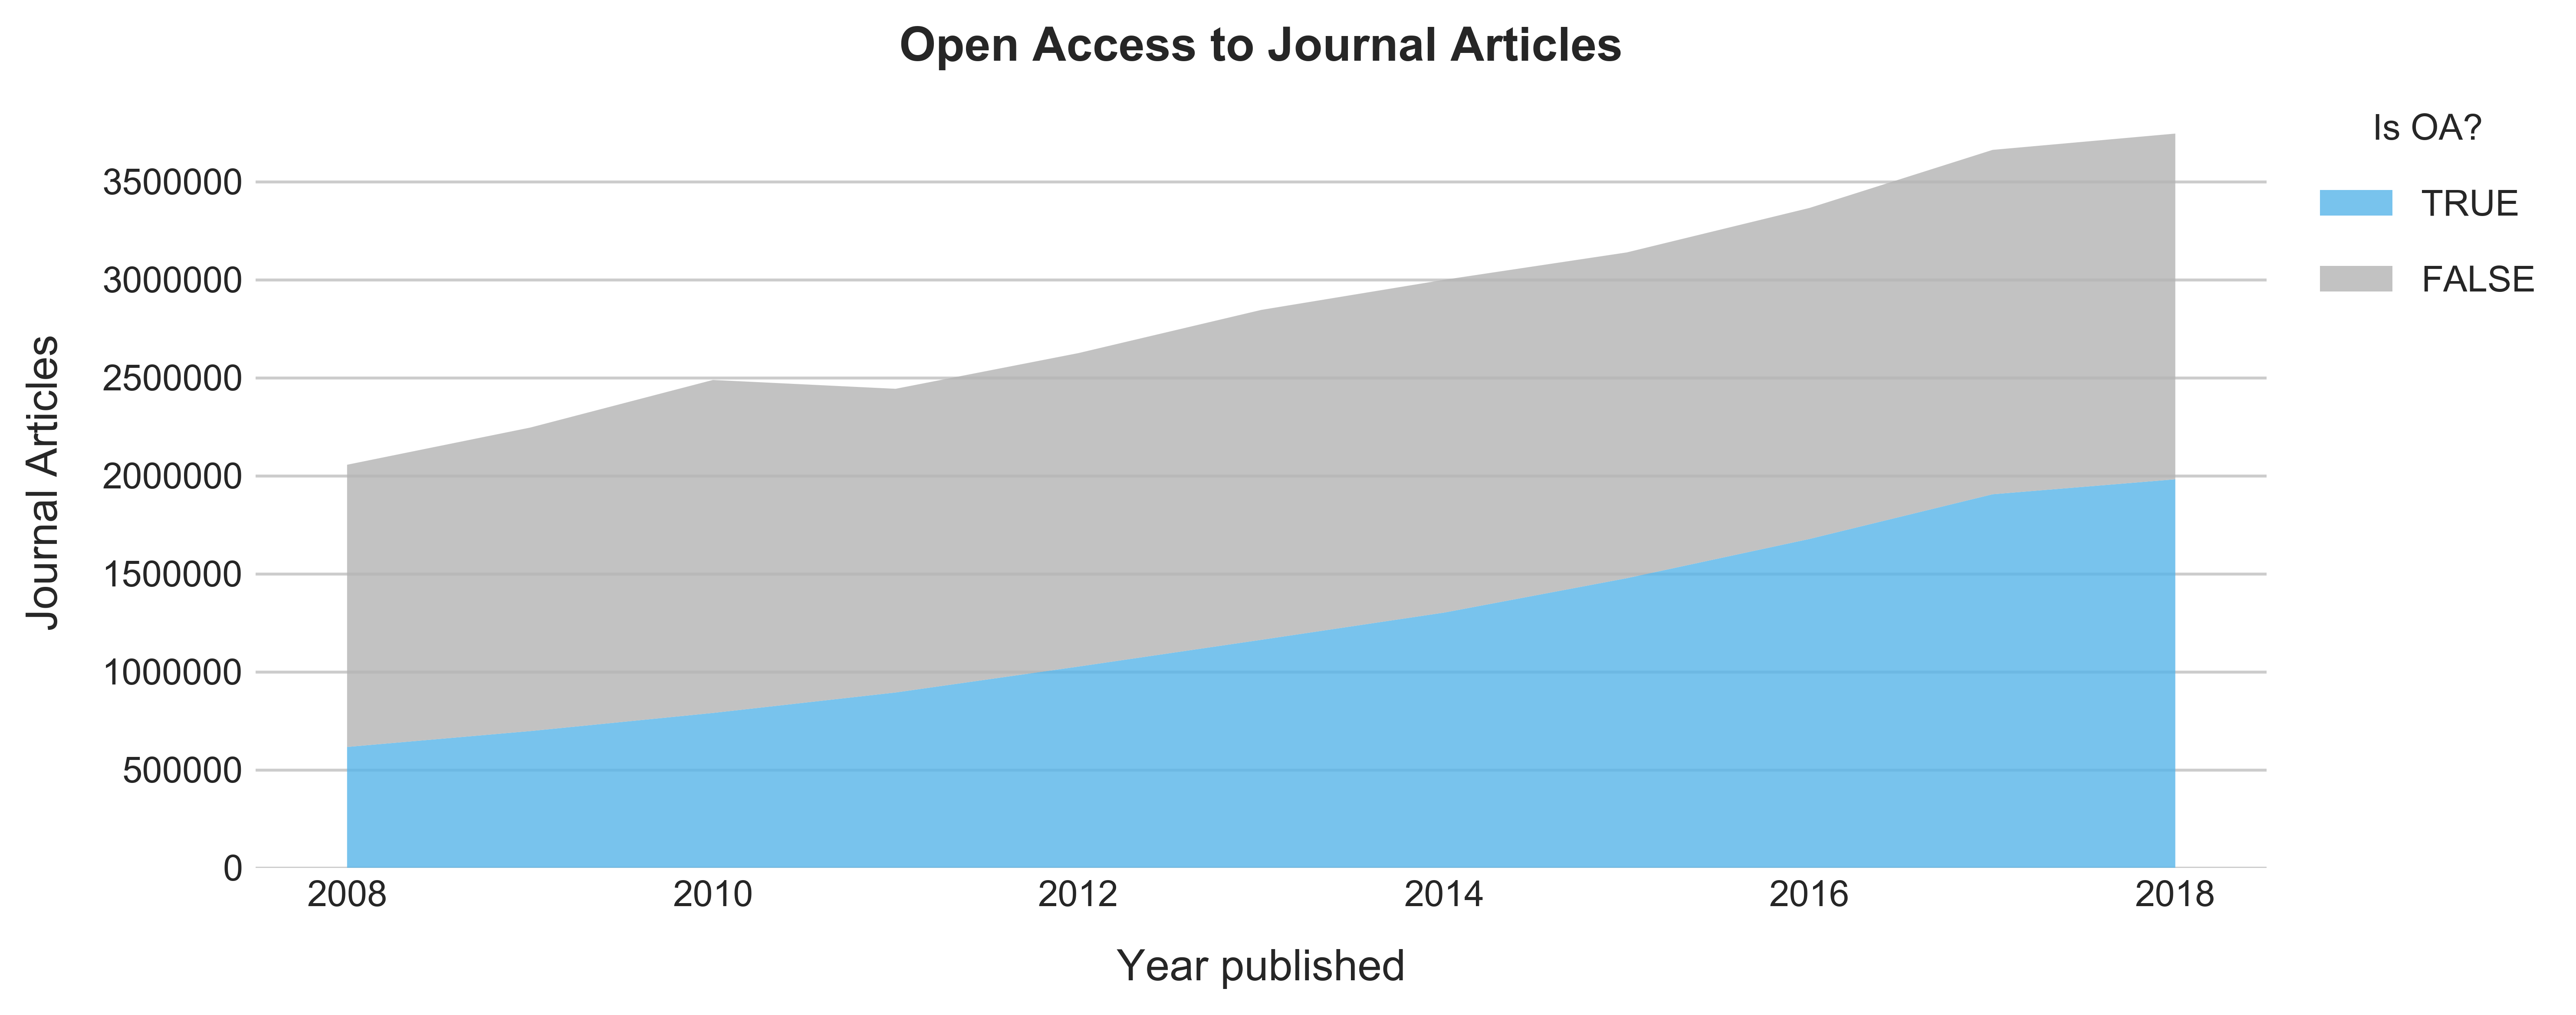

In [10]:
x = df.year.unique()
y1 = df[df.is_oa == True].n
y2 = df[df.is_oa == False].n

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [10, 4]
plt.grid(False, which='both', axis='x')
plt.box(False)

plt.stackplot(x, y1, y2, 
              labels=['TRUE', 'FALSE'],
              colors=['#56B4E9', '#b3b3b3a0'], 
              alpha=0.8)

plt.title('Open Access to Journal Articles', 
          fontdict={'fontsize': 13, 'fontweight': 600},
          pad=10)
plt.xlabel('Year published', labelpad=10, fontdict={'fontsize': 12, 'fontweight': 500})
plt.ylabel('Journal Articles', labelpad=10, fontdict={'fontsize': 12, 'fontweight': 500})

plt.legend(title='Is OA?', fontsize='medium', bbox_to_anchor=(1.15, 1.02), labelspacing=1.2)

plt.tight_layout()

plt.show()

As expected, the total number of journal articles has increased, compared to the previous results from the blog article. In fact, the number of articles with a distinct DOI included in the Unpaywall data dump from February 2020 has increased by 1.4% (regardless of paratexts that were not specified in previous database snapshots) in comparison to the February 2019 data dump used in the original blog post. In addition, the share of open access articles has increased by 6%. Overall, 13,527,352 freely available articles were published between 2008 and 2018. 

## Unpaywall Open Access Hosting Types (host_type)

Next, we investigate the differences between the distribution of the host types specified in the data dumps. The host type describes the type of location that serves open access full-texts and accepts two values: `publisher` and `repository`. As mentioned in the blog article, the host type variable is determined by Unpaywall’s algorithm. 

In [11]:
HOST_TYPE_08_12_QUERY = f"""
                        SELECT year, host_type, journal_is_in_doaj, 
                            COUNT(DISTINCT(doi)) AS number_of_articles 
                        FROM {upw_08_12}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" AND is_best=true AND is_paratext=False
                        GROUP BY year, host_type, journal_is_in_doaj
                        """

HOST_TYPE_13_18_QUERY = f"""
                        SELECT year, host_type, journal_is_in_doaj, 
                            COUNT(DISTINCT(doi)) AS number_of_articles 
                        FROM {upw_13_18}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" AND year<2019 AND is_best=true 
                            AND is_paratext=False
                        GROUP BY year, host_type, journal_is_in_doaj
                        """

Like in the aforementioned blog article, we create a `host` column with the pandas provided `loc` method to highlight freely available full-texts provided by DOAJ in addition to the regular host types. Because DOAJ ensures high quality standards and peer reviews for their indexed journals, it might be interesting to see whether an increase of publishing in potentially less strict open access journals can be observed or not. 

In [12]:
host_type_08_12_query_df = client.query(HOST_TYPE_08_12_QUERY).to_dataframe()
host_type_13_18_query_df = client.query(HOST_TYPE_13_18_QUERY).to_dataframe()

host_type_df = pd.concat([host_type_08_12_query_df, host_type_13_18_query_df])
host_type_df.year = pd.to_datetime(host_type_df.year.apply(lambda x: str(x) + "-01-01"))
host_type_df = host_type_df.sort_values(by=['year']).reset_index(drop=True)

host_type_df.loc[host_type_df['host_type'] == 'publisher', 'host'] = 'Other Journals'
host_type_df.loc[host_type_df['host_type'] == 'repository', 'host'] = 'Repositories only'
host_type_df.loc[host_type_df['journal_is_in_doaj'] == True, 'host'] = 'DOAJ-listed Journal'

host_type_df.head()

year   host_type  journal_is_in_doaj  number_of_articles  \
0 2008-01-01  repository               False              213820   
1 2008-01-01   publisher               False              309659   
2 2008-01-01   publisher                True               92590   
3 2009-01-01  repository               False              232924   
4 2009-01-01   publisher                True              114665   

                  host  
0    Repositories only  
1       Other Journals  
2  DOAJ-listed Journal  
3    Repositories only  
4  DOAJ-listed Journal

Again, we visualize our data with matplotlib. Unlike ggplots for R, we have a more inconvenient way to prepare and plot our data with matplotlib in Python. This starts by iterating over the host types to generate a subplot for each. Although, we can make use of pandas plotting methods to display complicated graphics from DataFrames, it requires much effort to get publication quality figures. 

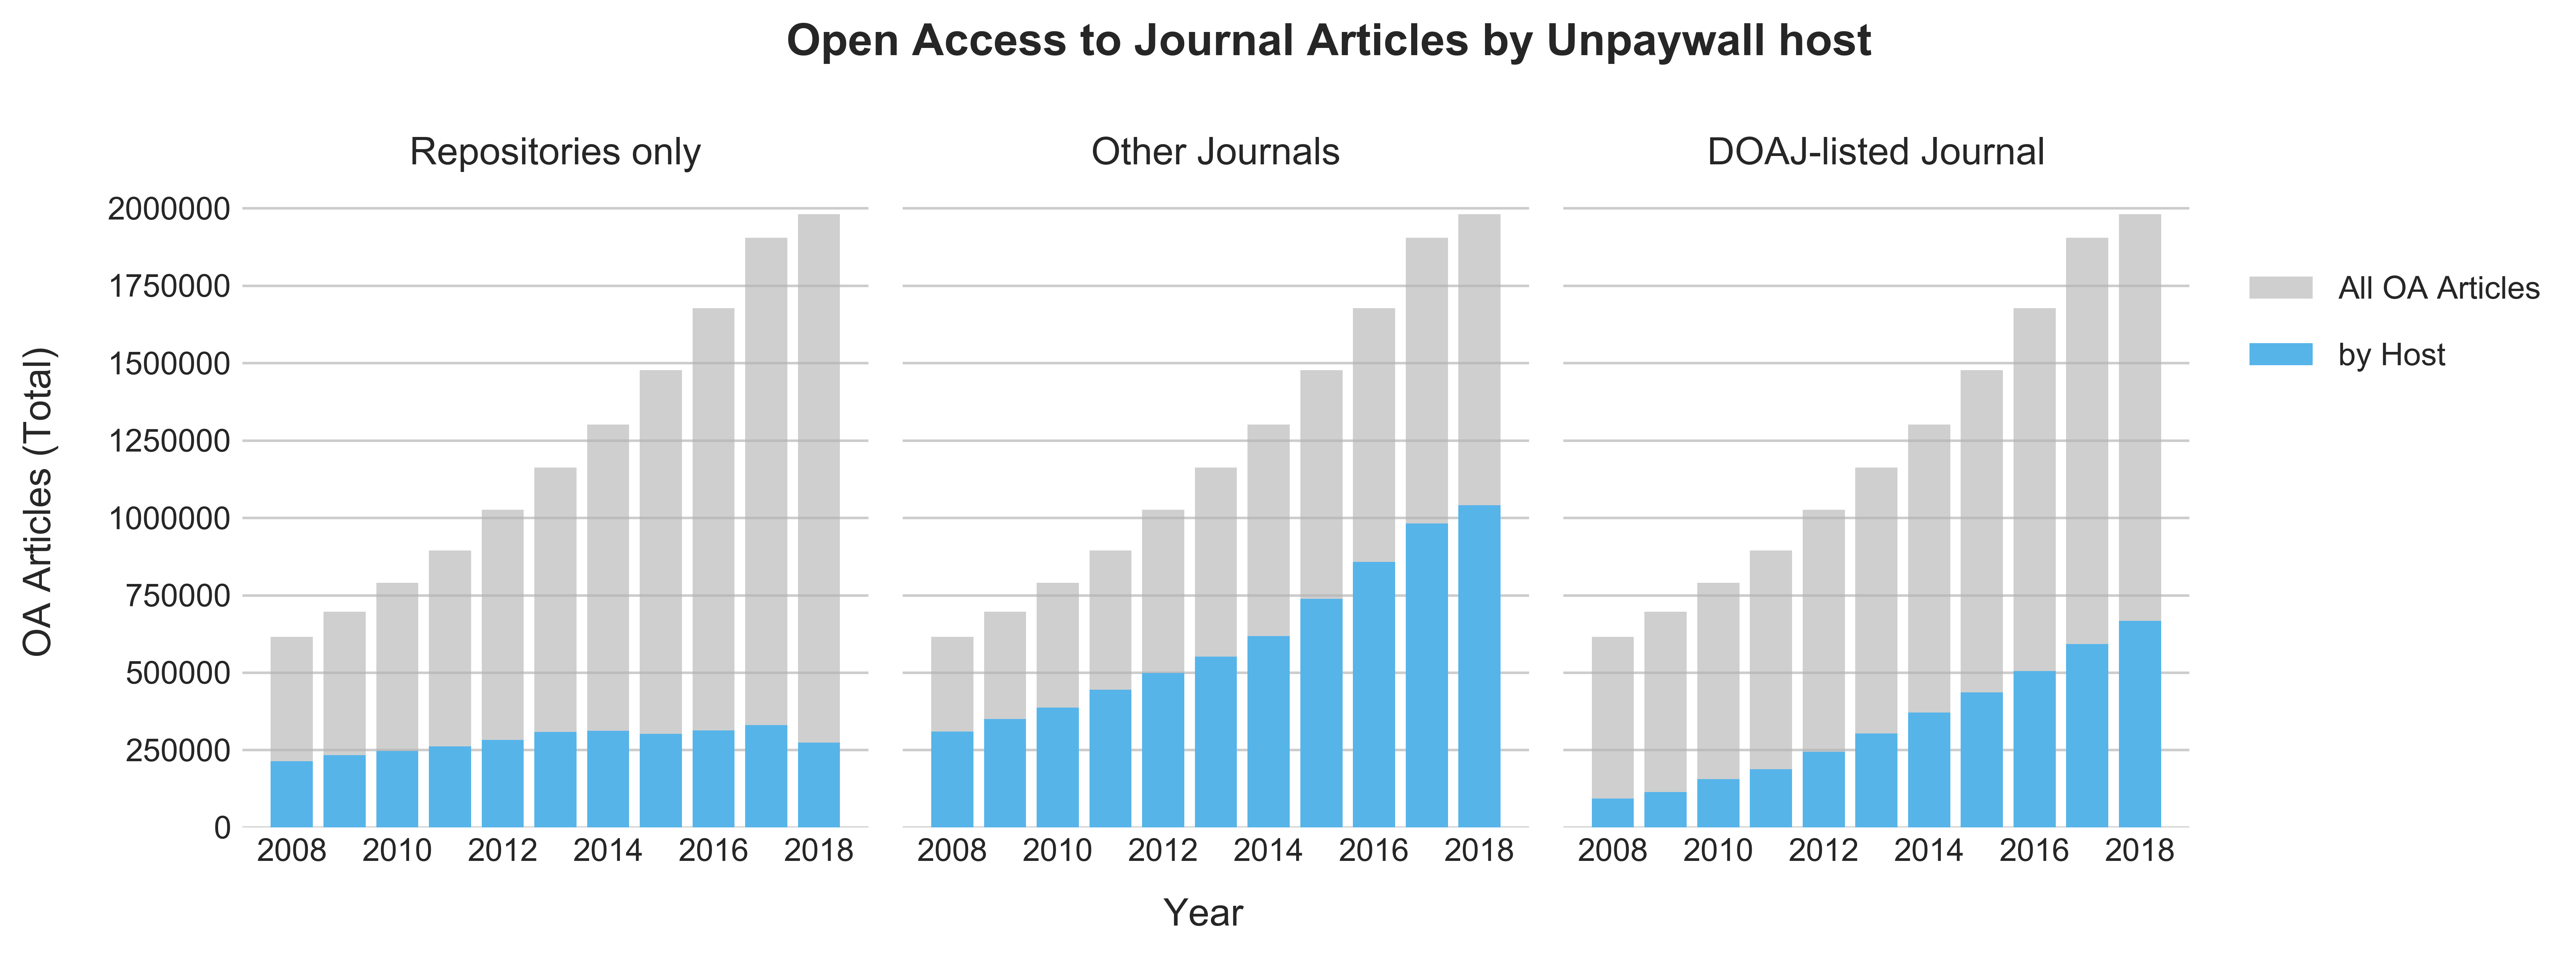

In [13]:
all_articles = host_type_df.groupby(['year'])['number_of_articles'].sum() \
                            .reset_index(name='number_of_articles')

x = all_articles['year'].dt.year
y_total = all_articles.number_of_articles

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [11, 3.5]

fig, axes = plt.subplots(nrows=1, ncols=3)

fig.suptitle('Open Access to Journal Articles by Unpaywall host', 
             fontsize=14, 
             fontweight=600, 
             y=1.10)

for i, host in enumerate(host_type_df.host.unique(), 1):
    
    ax = plt.subplot(1,3,i)
    
    y_stacked = host_type_df[host_type_df.host==host] \
                    .groupby(['year'])['number_of_articles'].sum() \
                    .reset_index(name='number_of_articles').number_of_articles
    
    ax.bar(x, y_total, color='#b3b3b3a0', label='All OA Articles')
    ax.bar(x, y_stacked, color='#56B4E9', label='by Host')
    
    ax.set_title(host, fontdict={'fontsize': 12, 'fontweight': 500})

    ax.set_frame_on(False)
    ax.grid(False, which='both', axis='x')
    ax.set(xlabel='', ylabel='')

    if i > 1:
        ax.set_yticklabels([], visible=False)
        
# common xlabel   
fig.text(0.45, -0.03, 'Year', ha='center', 
         fontdict={'fontsize': 12, 'fontweight': 500})

# common ylabel
fig.text(-0.02, 0.5, 'OA Articles (Total)', va='center', rotation='vertical', 
         fontdict={'fontsize': 12, 'fontweight': 500})

plt.legend(fontsize='medium', bbox_to_anchor=(1.05, 0.9), labelspacing=1.2)

fig.tight_layout()

plt.show()

As can be seen from the figure, the proportion of open access articles that are accessible through journals which are not listed in DOAJ has rapidly increased in the year 2018 in comparison to the previous results. Nonetheless, the overall share of articles obtained from Journals that are not listed in DOAJ has decreased from 56% to 50%. Consequently, the share of open access articles provided by DOAJ-listed journals has increased. 

## Unpaywall Open Access Evidence Types (evidence)

In the following, we explore varieties between the evidence types of the two data dumps. The evidence type is a variable determined by Unpaywall, which expresses the location at which an article was found and how Unpaywall was able to identify the open access status of an article.

In [14]:
EVIDENCE_08_12_QUERY = f"""
                        SELECT evidence, year, is_best, 
                            COUNT(DISTINCT(doi)) AS number_of_articles 
                        FROM {upw_08_12}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" AND is_paratext=False
                        GROUP BY evidence, year, is_best
                        """

EVIDENCE_13_18_QUERY = f"""
                        SELECT evidence, year, is_best, 
                            COUNT(DISTINCT(doi)) AS number_of_articles 
                        FROM {upw_13_18}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" AND year < 2019 AND is_paratext=False
                        GROUP BY evidence, year, is_best
                        """

In [15]:
evidence_08_12 = client.query(EVIDENCE_08_12_QUERY).to_dataframe()
evidence_13_18 = client.query(EVIDENCE_13_18_QUERY).to_dataframe()

In [16]:
evidence_df = pd.concat([evidence_08_12, evidence_13_18])
evidence_df.year = pd.to_datetime(evidence_df.year.apply(lambda x: str(x) + "-01-01"))

evidence_df.head()

evidence       year  is_best  \
0              oa repository (via OAI-PMH doi match) 2011-01-01     True   
1                   oa repository (via pmcid lookup) 2012-01-01    False   
2  oa repository (via OAI-PMH title and first aut... 2008-01-01     True   
3              oa repository (via OAI-PMH doi match) 2008-01-01     True   
4              oa repository (via OAI-PMH doi match) 2012-01-01    False   

   number_of_articles  
0              143863  
1              264943  
2               37283  
3              108646  
4              264888

For each evidence type we calculate the total number of articles and the related proportion, as well as the cumulative proportion regarding to the number of all articles. Then we display the results in form of a table. To specify the precision of the resulting floating point numbers we again make use of the Python built-in string formatting function. Here we specify by 2 digits of accuracy. 

In [17]:
articles_per_type_df = evidence_df.groupby(['evidence']).number_of_articles \
                        .sum() \
                        .to_frame() \
                        .reset_index() \
                        .sort_values(by=['number_of_articles'], ascending=False) \
                        .reset_index(drop=True)
    
articles_per_type_df['prop'] = articles_per_type_df['number_of_articles'] \
                                .transform(lambda x: 
                                           x / articles_per_type_df['number_of_articles'] \
                                           .sum() * 100)

articles_per_type_df['cumul'] = articles_per_type_df.prop.cumsum()

In [18]:
articles_per_type_table = articles_per_type_df.copy()
articles_per_type_table.prop = articles_per_type_table.prop \
                                    .apply(lambda x: '{0:.2f}'.format(x))

articles_per_type_table.cumul = articles_per_type_table.cumul \
                                    .apply(lambda x: '{0:.2f}'.format(x))

articles_per_type_table.columns = ['Evidence Types', 
                                   'Number of Articles', 
                                   'Proportion of all Articles in %', 
                                   'Cumulative Proportion in %']

articles_per_type_table

Evidence Types  Number of Articles  \
0               oa repository (via OAI-PMH doi match)             4829188   
1                                 open (via free pdf)             4733697   
2             oa repository (semantic scholar lookup)             4317376   
3                        open (via page says license)             4027715   
4                               oa journal (via doaj)             3596329   
5                    oa repository (via pmcid lookup)             3308388   
6   oa repository (via OAI-PMH title and first aut...             1789527   
7                   oa journal (via observed oa rate)             1095887   
8                         open (via crossref license)              577236   
9                             open (via free article)              193003   
10                   open (via page says Open Access)               94117   
11                    oa journal (via publisher name)               74289   
12     open (via crossref license, author manuscript)               71386   
13            oa repository (via OAI-PMH title match)               59580   
14  oa repository (via OAI-PMH title and last auth...               44073   
15                                             manual                  29   
16                     hybrid (via page says license)                   1   

   Proportion of all Articles in % Cumulative Proportion in %  
0                            16.76                      16.76  
1                            16.43                      33.19  
2                            14.98                      48.18  
3                            13.98                      62.15  
4                            12.48                      74.64  
5                            11.48                      86.12  
6                             6.21                      92.33  
7                             3.80                      96.13  
8                             2.00                      98.14  
9                             0.67                      98.81  
10                            0.33                      99.13  
11                            0.26                      99.39  
12                            0.25                      99.64  
13                            0.21                      99.85  
14                            0.15                     100.00  
15                            0.00                     100.00  
16                            0.00                     100.00

Interestingly, the evidence type with the third highest number of related articles was not included in the database snapshot used in the mentioned blog post. Further we can identify the same phenomenon as in the previous work, that the least frequent eight evidence types summarized only make up 1.9% of all articles in total. In the following we will collate these evidence types in the category `other`.

In [19]:
sum_other = articles_per_type_df \
                .loc[articles_per_type_df['prop'] < 1] \
                .number_of_articles \
                .sum()

articles_per_type_other_df = pd.DataFrame([['other', sum_other]], 
                                          columns=['evidence', 'number_of_articles'])

articles_per_type_keep_df = articles_per_type_df.loc[articles_per_type_df['prop'] > 1]

articles_per_type_grouped_df = pd.concat([articles_per_type_other_df, 
                                          articles_per_type_keep_df])

articles_per_type_grouped_df = articles_per_type_grouped_df \
                                .groupby(['evidence']) \
                                .number_of_articles.sum() \
                                .to_frame().reset_index() \
                                .sort_values(by=['number_of_articles'], ascending=False) \
                                .reset_index(drop=True)

articles_per_type_grouped_df['prop'] = articles_per_type_grouped_df['number_of_articles'] \
                        .transform(lambda x: 
                        x / articles_per_type_grouped_df['number_of_articles'].sum() * 100)

articles_per_type_grouped_df['cumul'] = articles_per_type_grouped_df.prop.cumsum()

In [20]:
evidence_grouped_df = evidence_df.copy()

list_of_small_evidence_types = articles_per_type_df \
                                .loc[articles_per_type_df['prop'] < 1] \
                                .evidence.tolist()

evidence_grouped_df.evidence = evidence_grouped_df \
                                .evidence.replace(list_of_small_evidence_types, 'other')

evidence_grouped_df = evidence_grouped_df.groupby(['evidence', 'is_best', 'year']) \
                                .number_of_articles.sum() \
                                .to_frame().reset_index() \
                                .sort_values(by=['number_of_articles'], ascending=False) \
                                .reset_index(drop=True)

To illustrate the best open access locations according to Unpaywall, we will visualize the quantity of articles that were obtained from data sources with the `is_best` attribute given by Unpaywall in contrast to the total number of articles found in each evidence type. 

This time we are using the [seaborn](https://seaborn.pydata.org/index.html) package for generating bar plots. Seaborn is a visualization library which is build on top of matplotlib. It is well designed to fit with pandas DataFrames and it also enables smoother plots. Also, we can continue to use matplotlib methods.

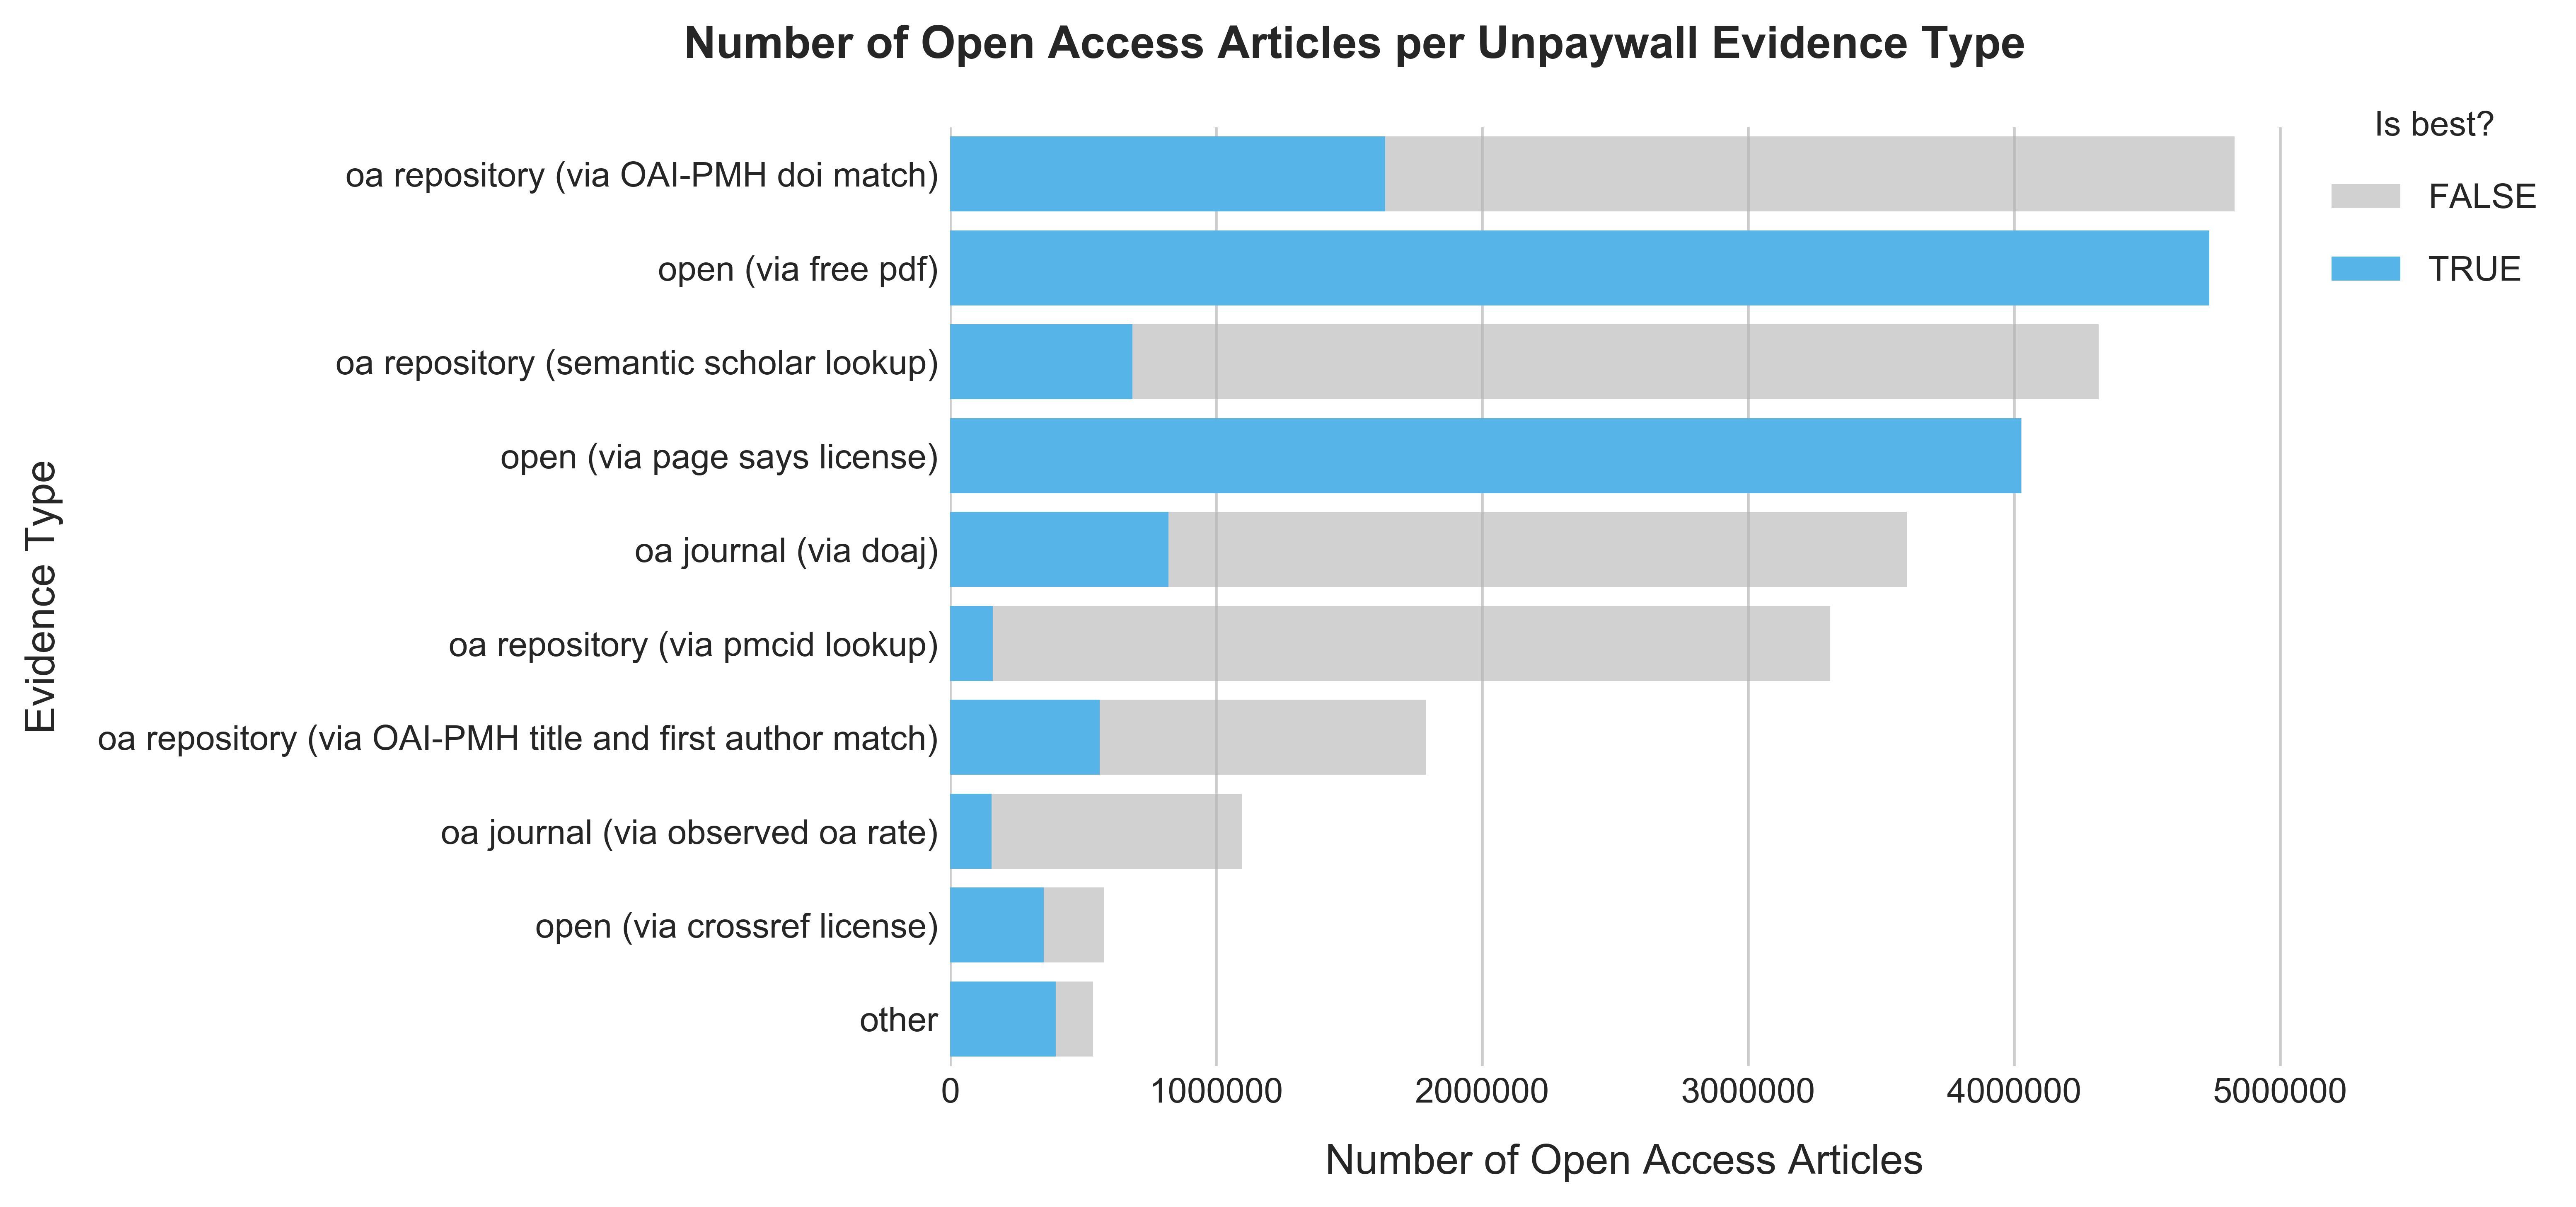

In [21]:
evidence_grouped_plot_df = evidence_grouped_df[evidence_grouped_df.is_best == True] \
                                .groupby(['evidence'])['number_of_articles'] \
                                .sum().to_frame() \
                                .reset_index() \
                                .rename(columns={'number_of_articles': 'is_best_sum'})

evidence_grouped_plot_df = pd.merge(articles_per_type_grouped_df, 
                                    evidence_grouped_plot_df,
                                    how='left',
                                    on='evidence')

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [7, 5]
plt.grid(False, which='both', axis='y')
plt.box(False)

ax1 = sns.barplot('number_of_articles',
                  'evidence',
                  data=evidence_grouped_plot_df,
                  label='FALSE',
                  color='#b3b3b3a0',
                  alpha=0.6, 
                  saturation=1)

ax2 = sns.barplot('is_best_sum', 
                  'evidence',
                  data=evidence_grouped_plot_df,
                  label='TRUE',
                  color='#56B4E9',
                  alpha=1, 
                  saturation=1)

plt.title('Number of Open Access Articles per Unpaywall Evidence Type', 
          fontdict={'fontsize': 13, 'fontweight': 600}, pad=20, x=0.3)
plt.xlabel('Number of Open Access Articles', labelpad=10, 
           fontdict={'fontsize': 12, 'fontweight': 500})

plt.ylabel('Evidence Type', labelpad=10, 
           fontdict={'fontsize': 12, 'fontweight': 500})

plt.legend(title='Is best?', fontsize='medium', bbox_to_anchor=(1.2, 1.05), labelspacing=1.2)


plt.show()

The figure provides two types of evidence that were not specifically mentioned in the previous work: `oa repository (semantic scholar lookup)` and `oa journal (via observed rate)`. Apparently, these evidence types are responsible for the overall increase in articles between the two data dumps from February 2019 and February 2020. Furthermore we can observe an increase of articles in repositories. Indeed, the evidence type with most associated articles is a repository. However, Unpaywall still prioritises publisher hosted content over repository depositions as can be seen. 

To distinguish the classification as best open access location of data sources by Unpaywall over time, we again make use of matplotlib. Although the FacetGrid function provided by seaborn would be very useful for this task it unfortunately doesn´t support stacked plots as mentioned in this [issue](https://github.com/mwaskom/seaborn/issues/1485) on GitHub.

In [22]:
x = evidence_grouped_df.sort_values(by=['year'], ascending=True) \
                        .reset_index(drop=False) \
                        ['year'].dt.year.unique()

plt.style.use('seaborn-whitegrid')

fig, axes = plt.subplots(nrows=5, 
                           ncols=2, 
                           sharex=True, 
                           sharey=True, 
                           figsize=(12,12))

# get a one-dimensional array
axes = axes.reshape(-1)

fig.suptitle('Unpaywall Open Access Evidence Categories per Year', 
             fontsize=15, 
             fontweight=600, 
             x=0.53,
             y=1.04)

for i, ax in enumerate(axes, 1):
    
    ax = plt.subplot(5,2,i, sharey=axes[0], sharex=axes[0])    
    
    if i % 2 == 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    
    evidence = evidence_grouped_df.evidence.unique()[i-1]

    y_total = evidence_grouped_df[evidence_grouped_df.evidence == evidence] \
                            .groupby(['year']) \
                            .number_of_articles.sum() \
                            .to_frame().reset_index() \
                            .number_of_articles

    y_stacked = evidence_grouped_df[evidence_grouped_df.evidence == evidence] \
                            .loc[evidence_grouped_df.is_best == True] \
                            .groupby(['year']) \
                            .number_of_articles.sum() \
                            .to_frame().reset_index() \
                            .number_of_articles

    ax = plt.bar(x, y_total, color='#b3b3b3a0')
    ax = plt.bar(x, y_stacked, color='#56B4E9')
    plt.title(evidence, fontdict={'fontsize': 12, 'fontweight': 500}, pad=0.2)
    
    plt.grid(False, which='both', axis='x')
    plt.box(False)

# common xlabel   
fig.text(0.52, -0.03, 'Publication Year', ha='center', 
         fontdict={'fontsize': 13, 'fontweight': 500})

# common ylabel
fig.text(-0.04, 0.5, 'Number of Open Access Articles', va='center', rotation='vertical', 
         fontdict={'fontsize': 13, 'fontweight': 500})

is_best_patch = mpatches.Patch(color='#56B4E9', label='TRUE')
is_not_best_patch = mpatches.Patch(color='#b3b3b3a0', label='FALSE')
fig.legend(handles=[is_best_patch, is_not_best_patch], title='Is best?', 
           fontsize='large', title_fontsize='x-large', 
           bbox_to_anchor=(1.15, 0.95), labelspacing=1.2)

plt.tight_layout()

plt.show()

## Overlap of Open Access Provision and Evidence Types

Owing to possible multiple associations between an article and evidence types in Unpaywall, we investigate the intersection between host types in the next step. Again, we compare the results with the previous results.

### Overlap between Host Types

In [23]:
HOST_TYPE_INTERSECT_08_12_QUERY = f"""
                                    SELECT year, host_type_count, 
                                        COUNT(DISTINCT(doi)) AS number_of_articles 
                                    FROM 
                                        (SELECT doi, year,
                                            STRING_AGG(DISTINCT(host_type) 
                                        ORDER BY host_type) AS host_type_count 
                                        FROM {upw_08_12}, UNNEST (oa_locations)
                                        WHERE genre="journal-article" AND is_paratext=False
                                        GROUP BY doi, year) 
                                    GROUP BY host_type_count, year 
                                    ORDER BY number_of_articles DESC
                                    """

HOST_TYPE_INTERSECT_13_18_QUERY = f"""
                                    SELECT year, host_type_count, 
                                        COUNT(DISTINCT(doi)) AS number_of_articles 
                                    FROM 
                                        (SELECT doi, year, 
                                        STRING_AGG(DISTINCT(host_type) 
                                        ORDER BY host_type) AS host_type_count
                                        FROM {upw_13_18}, UNNEST (oa_locations) 
                                        WHERE genre="journal-article" AND year < 2019 
                                            AND is_paratext=False
                                        GROUP BY doi, year) 
                                    GROUP BY host_type_count, year 
                                    ORDER BY number_of_articles DESC
                                    """

We start by quering the project-database and setting up our dataframe. Then we will merge the outcome with the `articles_total_by_year` dataframe which we have created before. This enables us, to investigate the relative share of articles provided by different host types to the total number of articles across host types.

In [24]:
host_type_08_12_intersect_df = client.query(HOST_TYPE_INTERSECT_08_12_QUERY).to_dataframe()
host_type_13_18_intersect_df = client.query(HOST_TYPE_INTERSECT_13_18_QUERY).to_dataframe()
host_type_intersect_df = pd.concat([host_type_08_12_intersect_df, 
                                    host_type_13_18_intersect_df])

host_type_intersect_df.year = pd.to_datetime(host_type_intersect_df.year \
                                             .apply(lambda x: str(x) + "-01-01"))

host_type_intersect_df \
    .loc[host_type_intersect_df['host_type_count'] == 'publisher', 'host'] = 'Publisher only'
host_type_intersect_df \
    .loc[host_type_intersect_df['host_type_count'] == 'publisher,repository', 
         'host'] = 'Publisher & Repository'
host_type_intersect_df \
    .loc[host_type_intersect_df['host_type_count'] == 'repository', 
         'host'] = 'Repositories only'

In [25]:
articles_total_by_year_df = df.groupby(['year']).n.sum().to_frame().reset_index()
articles_total_by_year_df.columns = ['year', 'all_articles']

host_type_intersect_df = pd.merge(articles_total_by_year_df, 
                                  host_type_intersect_df, on='year', how='right')

host_type_intersect_df = host_type_intersect_df.groupby(['year', 'host']) \
                                    .sum().eval('prop = number_of_articles/all_articles') \
                                    .reset_index()

host_type_intersect_df.head()

year                    host  all_articles  number_of_articles  \
0 2008-01-01  Publisher & Repository       2055538              187109   
1 2008-01-01          Publisher only       2055538              215140   
2 2008-01-01       Repositories only       2055538              213820   
3 2009-01-01  Publisher & Repository       2245178              221294   
4 2009-01-01          Publisher only       2245178              242927   

       prop  
0  0.091027  
1  0.104664  
2  0.104021  
3  0.098564  
4  0.108199

In [26]:
host_type_all = host_type_intersect_df.copy()
host_type_all['prop'] = host_type_intersect_df.groupby(['year'])['prop'] \
                    .transform(lambda x: x.sum())

Again, we are using seaborn to display the results.

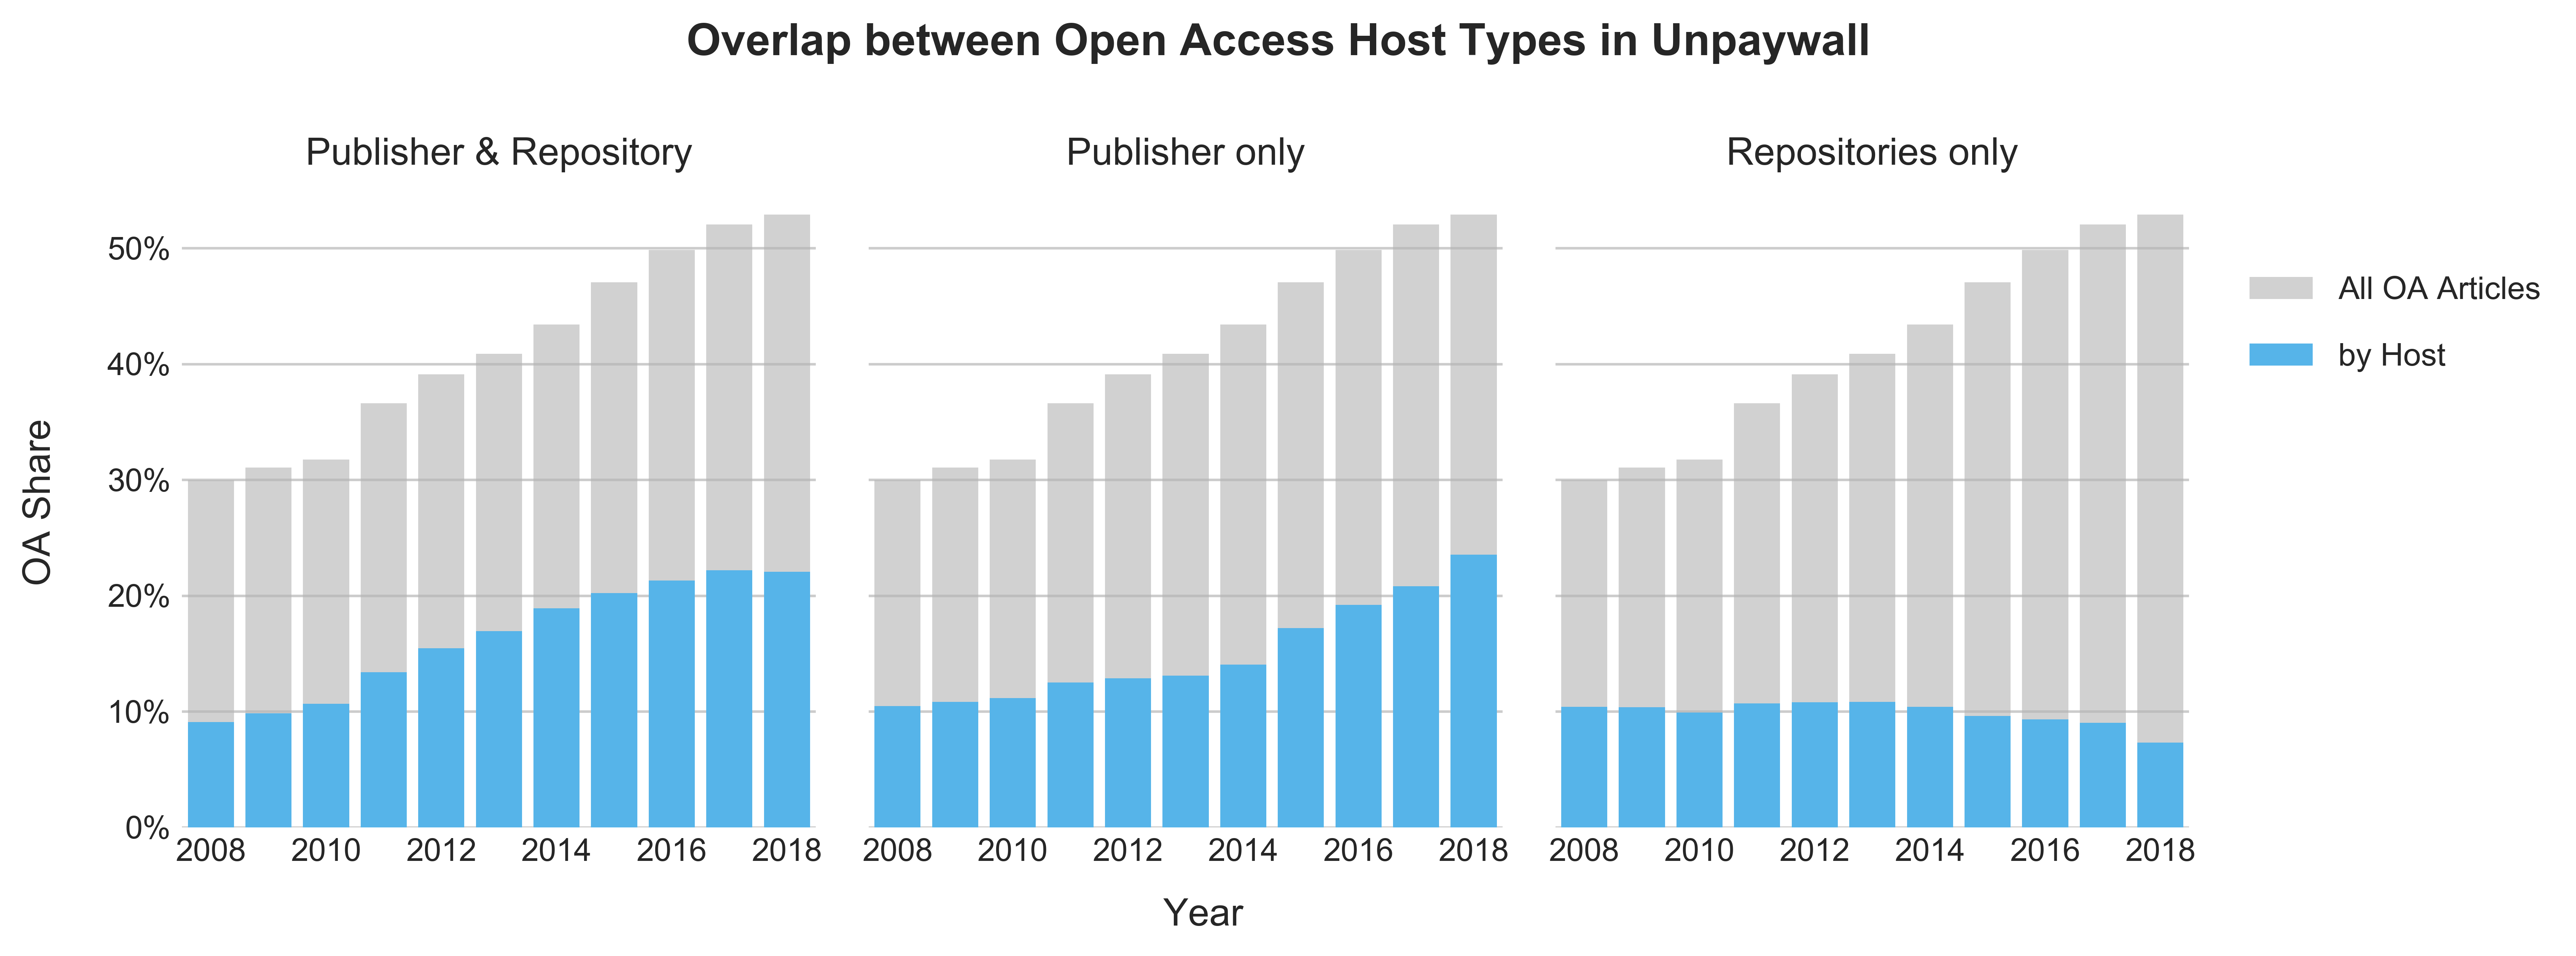

In [27]:
# convert year column to work properly with seaborn
x = host_type_intersect_df['year'].dt.year

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [11, 3.5] 

fig, axes = plt.subplots(nrows=1, ncols=3)

fig.suptitle('Overlap between Open Access Host Types in Unpaywall', 
             fontsize=14, 
             fontweight=600,
             x=0.48,
             y=1.10)
    
for i, host in enumerate(host_type_intersect_df.host.unique(), 1):
    ax = plt.subplot(1,3,i)
    y_stacked = host_type_intersect_df[host_type_intersect_df.host == host].prop
    sns.barplot(x, 
                'prop', 
                data=host_type_all,
                color='#b3b3b3a0', 
                label='All OA Articles',
                alpha=0.6, 
                saturation=1, 
                ci=None)
    
    sns.barplot(x, 
                y_stacked,
                color='#56B4E9', 
                label='by Host',
                alpha=1, 
                saturation=1, 
                ci=None)
    
    ax.set_title(host, fontdict={'fontsize': 12, 'fontweight': 500})
    
    ax.set_frame_on(False)
    ax.grid(False, which='both', axis='x')
    ax.set(xlabel='', ylabel='')
    
    # for readability we hide every second tick on the x axis
    for label in ax.get_xticklabels()[1::2]:
        label.set_visible(False)
        
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    if i > 1:
        ax.set_yticklabels([], visible=False)
        
# common xlabel   
fig.text(0.45, -0.03, 'Year', ha='center', 
         fontdict={'fontsize': 12, 'fontweight': 500})

# common ylabel
fig.text(-0.02, 0.5, 'OA Share', va='center', rotation='vertical', 
         fontdict={'fontsize': 12, 'fontweight': 500})
    
plt.legend(bbox_to_anchor=(1.05, 0.9), labelspacing=1.2)

plt.tight_layout()

plt.show()

The figure shows that, in terms of percentage, fewer articles were found on publisher websites than in the results of the blog article. Indeed, 77% of all open access full-texts are available through publisher websites which is a total of 10,448,559 articles. Relatively speaking, this is a decrease by almost 5% compared to the previous results. Also, the proportion of articles that are not archived in a repository has declined from 56% to 37%. Consequently, the proportion of articles that are available from both the publisher websites, as well as those that are archived in a repository have increased from 26% to 40%.

### Overlaps between Evidence types

So far, we investigated the overlap of host types in Unpaywall in this section. However various articles are associated with multiple evidence types in Unpaywall as mentioned at the beginning of this section, so that we examine the intersection between evidence types in the next step.

In [28]:
EVIDENCE_SINGLE_CAT_08_12_QUERY = f"""
                                    SELECT ev_cat, COUNT(DISTINCT(doi)) AS number_of_articles
                                    FROM 
                                        (SELECT doi, STRING_AGG(DISTINCT(evidence), "&" 
                                        ORDER BY evidence) AS ev_cat
                                        FROM {upw_08_12}, UNNEST (oa_locations)
                                        WHERE genre="journal-article" AND is_paratext=False
                                        GROUP BY doi
                                        )
                                    GROUP BY ev_cat
                                   """

EVIDENCE_SINGLE_CAT_13_18_QUERY = f"""
                                    SELECT ev_cat, COUNT(DISTINCT(doi)) AS number_of_articles
                                    FROM 
                                        (SELECT doi, STRING_AGG(DISTINCT(evidence), "&" 
                                        ORDER BY evidence) AS ev_cat
                                        FROM {upw_13_18}, UNNEST (oa_locations)
                                        WHERE genre="journal-article" AND year < 2019
                                            AND is_paratext=False
                                        GROUP BY doi
                                        )
                                    GROUP BY ev_cat
                                   """

In [29]:
evidence_categories_08_12_df = client.query(EVIDENCE_SINGLE_CAT_08_12_QUERY).to_dataframe()
evidence_categories_13_18_df = client.query(EVIDENCE_SINGLE_CAT_13_18_QUERY).to_dataframe()
evidence_categories_df = pd.concat([evidence_categories_08_12_df, 
                                    evidence_categories_13_18_df])

evidence_categories_df = evidence_categories_df.groupby(['ev_cat']) \
                                    .sum().reset_index() \
                                    .sort_values(by=['number_of_articles'], ascending=False) \
                                    .reset_index(drop=True)

evidence_categories_df.head()

ev_cat  number_of_articles
0                                open (via free pdf)             2152151
1              oa repository (via OAI-PMH doi match)              710660
2  oa repository (semantic scholar lookup)&open (...              703308
3            oa repository (semantic scholar lookup)              650348
4  oa repository (via OAI-PMH doi match)&oa repos...              577020

Again, we merge our dataframe with a previous created dataframe called `evidence_df`. Then we compute the frequency of open access full-texts related to a single data source. The result can be contrasted with the total number of articles found in each evidence type.

In [30]:
evidence_single_cat_df = evidence_df.groupby(['evidence']) \
                                .number_of_articles.sum() \
                                .reset_index()

evidence_single_cat_df = pd.merge(evidence_single_cat_df, evidence_categories_df, 
                                 how='left', left_on=['evidence'], right_on=['ev_cat']) \
                                    .drop(['ev_cat'], axis=1) 

evidence_single_cat_df.columns = ['evidence', 'number_of_articles', 'number_of_single_cat']

In [31]:
evidence_single_cat_df.evidence = evidence_single_cat_df \
                                    .evidence.replace(list_of_small_evidence_types, 'other')

evidence_single_cat_grouped_df = evidence_single_cat_df.groupby(['evidence']) \
                                    .sum() \
                                    .eval('prop = number_of_single_cat/number_of_articles') \
                                    .reset_index() \
                                    .sort_values(by=['number_of_articles'], ascending=False) \
                                    .reset_index(drop=True)

evidence_single_cat_grouped_df['number_of_single_cat'] = evidence_single_cat_grouped_df \
                                                    .number_of_single_cat \
                                                    .astype(int)

evidence_single_cat_grouped_df

evidence  number_of_articles  \
0              oa repository (via OAI-PMH doi match)             4829188   
1                                open (via free pdf)             4733697   
2            oa repository (semantic scholar lookup)             4317376   
3                       open (via page says license)             4027715   
4                              oa journal (via doaj)             3596329   
5                   oa repository (via pmcid lookup)             3308388   
6  oa repository (via OAI-PMH title and first aut...             1789527   
7                  oa journal (via observed oa rate)             1095887   
8                        open (via crossref license)              577236   
9                                              other              536478   

   number_of_single_cat      prop  
0                710660  0.147159  
1               2152151  0.454645  
2                650348  0.150635  
3                541619  0.134473  
4                376791  0.104771  
5                123660  0.037378  
6                438155  0.244844  
7                123076  0.112307  
8                245646  0.425556  
9                246442  0.459370

Next, we visualize our result in a horizontal barplot. For each evidence type we display the unique occurences across related articles. 

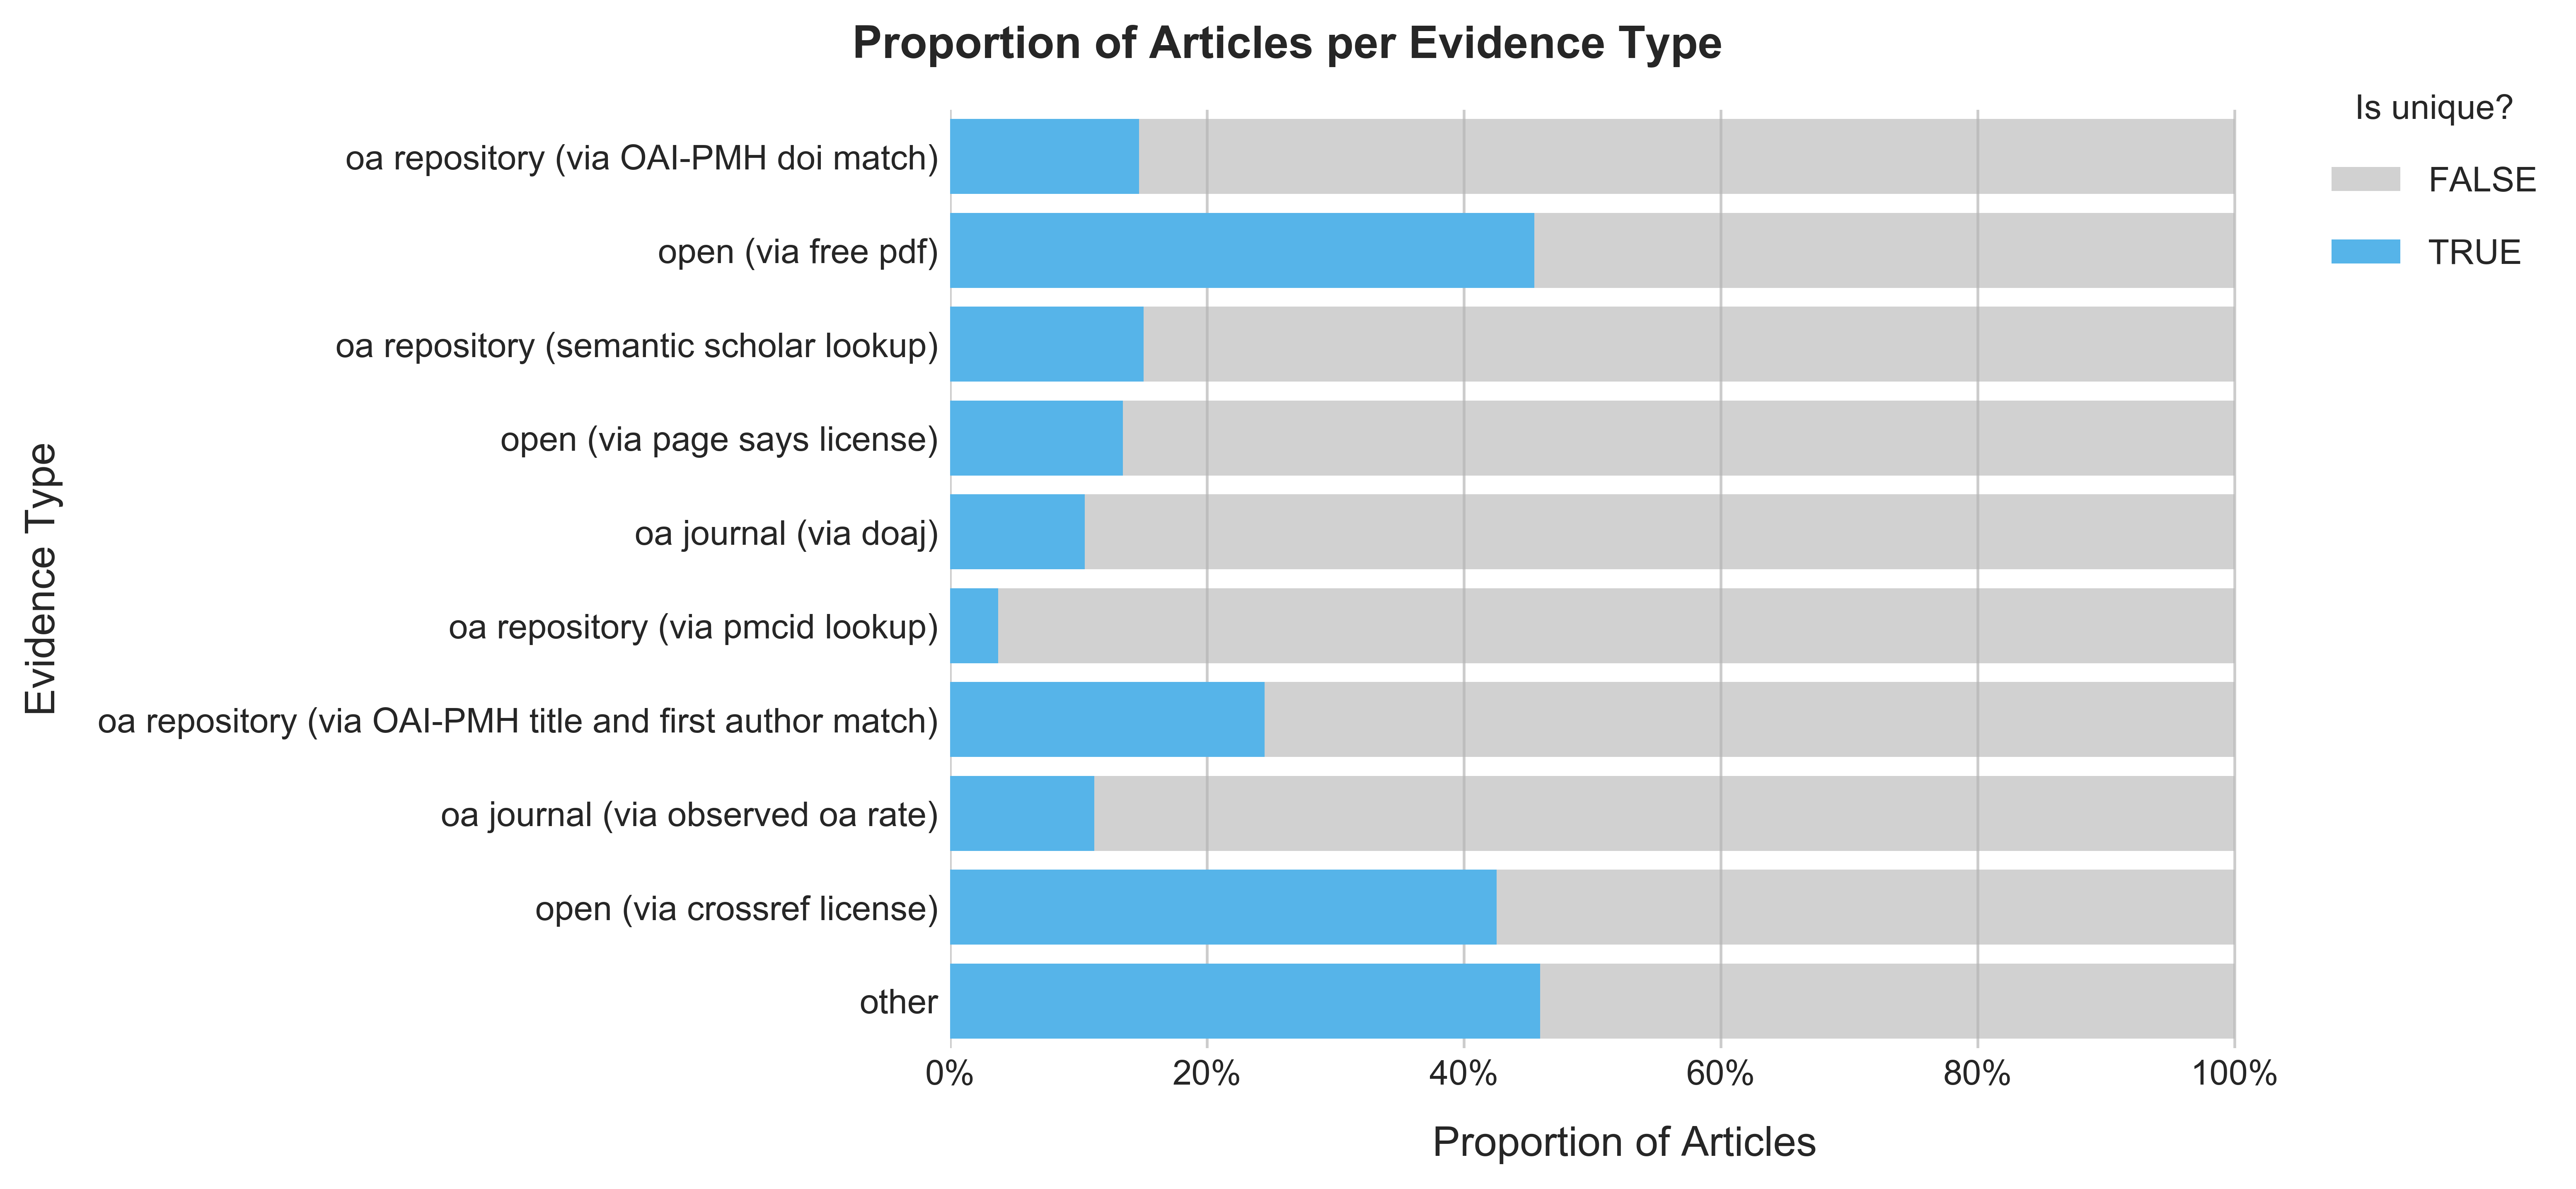

In [32]:
fig, axes = plt.subplots(figsize=(7,5))

plt.style.use('seaborn-whitegrid')
plt.grid(False, which='both', axis='y')
plt.box(False)

ax1 = sns.barplot(x=[1] * len(evidence_single_cat_grouped_df), 
                  y='evidence', 
                  data=evidence_single_cat_grouped_df, 
                  label='FALSE', 
                  color='#b3b3b3a0',
                  saturation=1,
                  alpha=0.6
                 )

ax2 = sns.barplot(x='prop', 
                  y='evidence', 
                  data=evidence_single_cat_grouped_df, 
                  label='TRUE', 
                  color='#56B4E9',
                  saturation=1,
                  alpha=1
                 )

axes.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title('Proportion of Articles per Evidence Type', 
          fontdict={'fontsize': 13, 'fontweight': 600}, x=0.25, pad=15)
plt.xlabel('Proportion of Articles', labelpad=10, 
           fontdict={'fontsize': 12, 'fontweight': 500})

plt.ylabel('Evidence Type', labelpad=10, 
           fontdict={'fontsize': 12, 'fontweight': 500})

axes.legend(title='Is unique?', 
            fontsize='medium', 
            bbox_to_anchor=(1.2, 1.05), 
            labelspacing=1.2)

plt.show()

While openly forms of open access provision identified via pdf or license are still evidence types with a most often unique appearance, it can be seen that the share has decreased, compared to the results from the previous database snapshot. On the other hand, the share of unique occurences of less frequent evidence types which were collated in the category other has increased rapidly. 

To visualize the intersection between multiple evidence types, we are using the [UpSetPlot](https://upsetplot.readthedocs.io/en/stable/) package which is better maintained in contrast to [py-upset](https://github.com/ImSoErgodic/py-upset). It offers better support for pandas and is also well documented. Especially the input format for the UpSet plot is well described.

The input format can be generated with the `from_memberships` method. It accepts two parameters: a nested list with elements corresponding to a set and secondly a list containing additional data which has the same length as the nested list.

In [33]:
evidence_categories_upset_df = evidence_categories_df.groupby(['ev_cat']) \
                                        .sum().reset_index() \
                                        .sort_values(by=['number_of_articles'], 
                                                     ascending=False) \
                                        .reset_index(drop=True)

In [34]:
# subset of fifteen most frequent distinct evidence types combinations
evidence_categories_upset_most_frequent = evidence_categories_upset_df[:15]

ev_list = evidence_categories_upset_most_frequent.ev_cat.tolist()
ev_list = [ev.split('&') for ev in ev_list]
n_list = evidence_categories_upset_most_frequent.number_of_articles.tolist()
evidence_categories_upset_expr = upsetplot.from_memberships(ev_list, data=n_list)

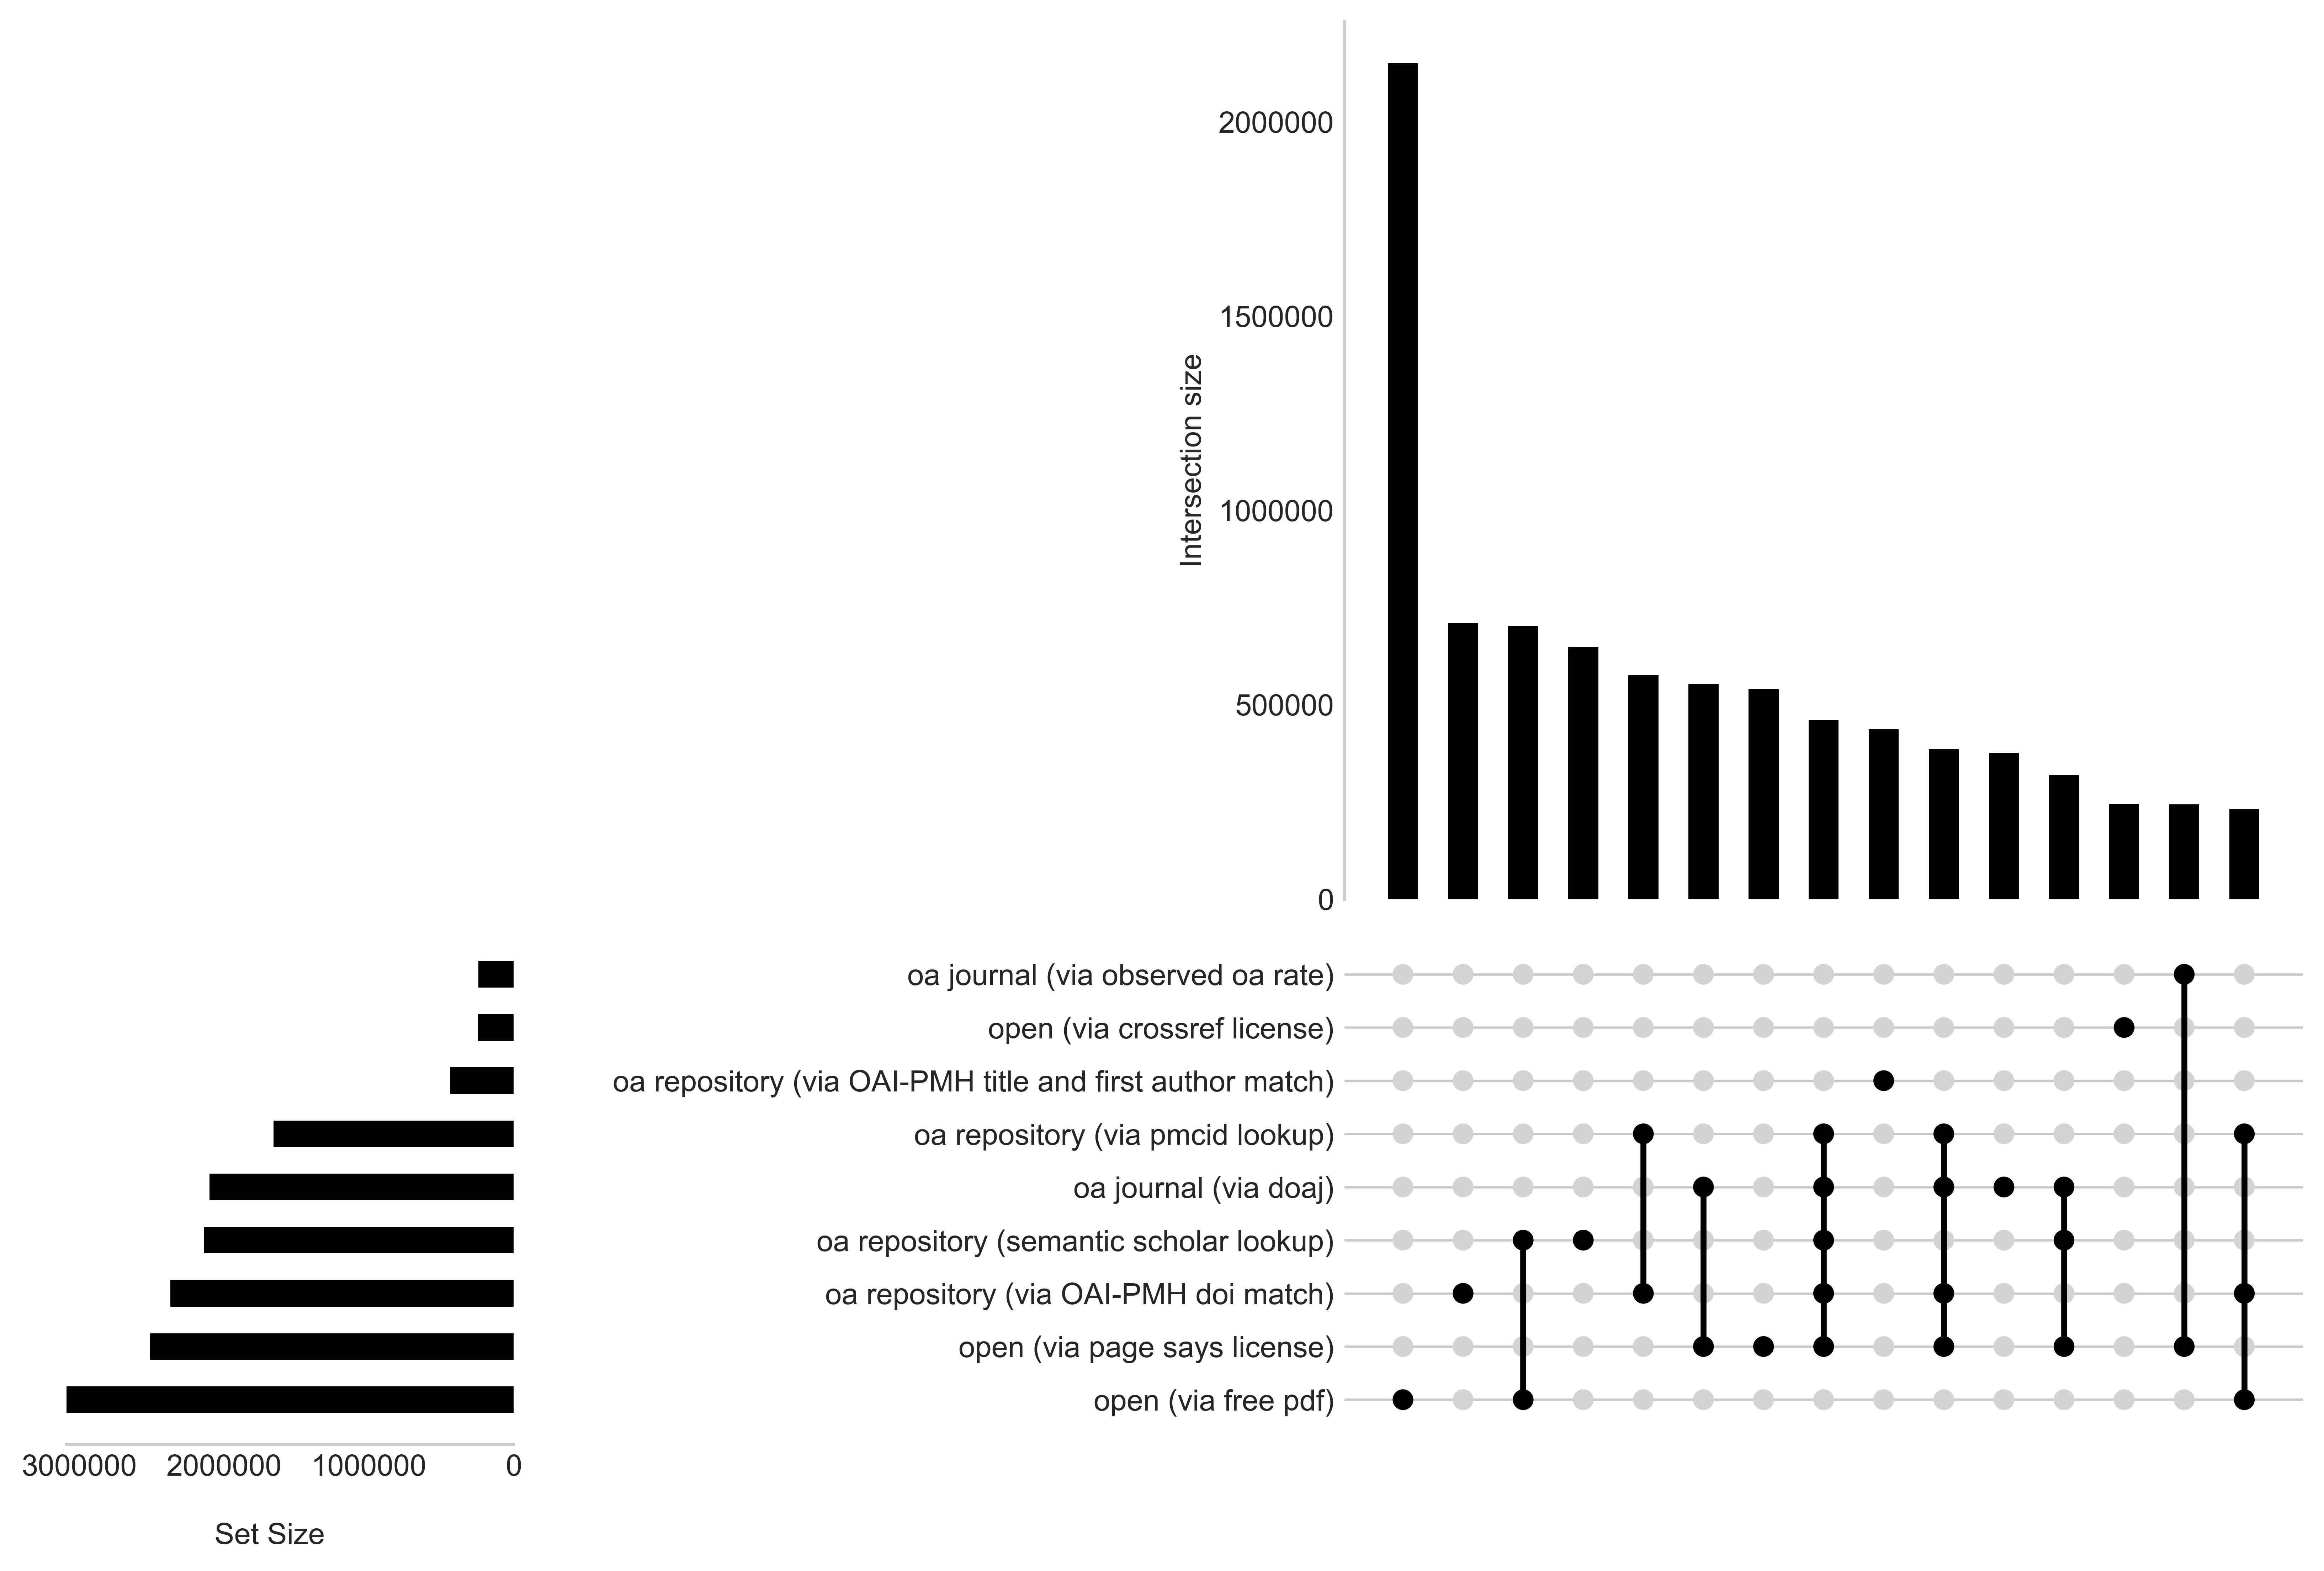

In [35]:
fig = plt.figure(figsize=(10,6))

axes = upsetplot.UpSet(evidence_categories_upset_expr, 
                sort_by='cardinality',
                sort_categories_by='cardinality',
                element_size=20, 
                intersection_plot_elements=15, 
                totals_plot_elements=7
               ).plot(fig=fig)

axes['intersections'].yaxis.grid(False)

axes['totals'].xaxis.grid(False)

# reduce overlap with text
plt.subplots_adjust(left=0, bottom=0, right=1.1, top=1, wspace=0, hspace=0)

fig.text(0.1, -0.07, 'Set Size', ha='center', 
         fontdict={'fontsize': 10, 'fontweight': 500})

# delete shading axis for better readability
fig.delaxes(axes['shading'])
    
plt.show()

## Discussion and Conclusion

In this blog post, we provided an updated analysis of open access evidences in Unpaywall by examining database snapshots obtained from Unpaywall. Using Python, we were able to find 13,527,352 scholarly articles in Unpaywall in the period from 2008 to 2018, that are freely available. Fortunately, we can compare these results with the previous database snapshot from February 2019 which were described in the mentioned blog article. Thusly we can interpret upcoming trends more precisely. 

Based on the previous results, our analysis exposes an increase of open access full-texts by 6% from 37% to 43%. Furthermore, we were able to identify new evidence types that were introduced in the recently released database snapshots. Though the results should be viewed with caution, since we have excluded DOI’s that were identified as paratexts which was not the case in the previous work. Eventually, we suggest that more articles had left closed access and Unpaywall was able to link more DOI’s to articles found in the newly introduced evidence types. We can also confirm the rise of repositories as hosting provider of online content. Despite that, publishing in DOAJ-listed journals is also slowly becoming more popular.

Additionally this work demonstrates similarities between data analysis in Python and R. Due to the fact that this work is based on translated R source code, we would be pleased to facilitate and encourage R users to work with Python, as well as Python users to work with the Unpaywall database. 